In [1]:
import pandas as pd
import numpy as np

In [2]:
X_train = pd.read_csv('/kaggle/input/nk-sec/X_train .csv')
X_test = pd.read_csv('/kaggle/input/nk-sec/X_test_call.csv')
Y_train_call = pd.read_csv('/kaggle/input/nk-sec/Y_train_call.csv')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from itertools import combinations

class IVTrainingDataCurator:
    def __init__(self, X_train, Y_train_call, X_test, min_strikes=4, max_strikes=8):
        self.X_train = X_train  # (n_samples, 43) - underlying + 42 market features
        self.Y_train_call = Y_train_call  # (n_samples, n_strikes) - all IV values
        self.X_test = X_test  # (n_samples, 43 + n_strikes) - contains NaNs in IV columns
        self.min_strikes = min_strikes
        self.max_strikes = max_strikes
        
        # Extract strike columns from test data (they contain the IV values)
        # Assuming columns are like: 'underlying', 'call_iv_24000', 'call_iv_24100', ..., 'X0', 'X1', ..., 'X41'
        self.iv_columns = [col for col in X_test.columns if 'call_iv_' in col]
        self.market_columns = [col for col in X_test.columns if col.startswith('X') and col[1:].isdigit()]
        self.underlying_col = 'underlying'  # Assuming this is the column name
        
        # Extract strike prices from IV column names
        self.strike_prices = sorted([float(col.split('call_iv_')[1]) for col in self.iv_columns])
        self.strike_to_col = {strike: f'call_iv_{int(strike)}' for strike in self.strike_prices}
        
        # Get training strike columns from Y_train_call
        self.train_strike_columns = list(Y_train_call.columns)
        self.train_strike_prices = sorted([float(col.split('call_iv_')[1]) for col in self.train_strike_columns])
        
        print(f"Training strikes: {self.train_strike_prices}")
        print(f"Test strikes: {self.strike_prices}")
        print(f"Training strike range: {min(self.train_strike_prices)} - {max(self.train_strike_prices)}")
        print(f"Test strike range: {min(self.strike_prices)} - {max(self.strike_prices)}")
        
    def extract_test_non_nan_data(self):
        """
        Extract non-NaN IV values from test data to use as additional training data
        """
        test_samples = []
        
        for idx, row in self.X_test.iterrows():
            # Extract market features and underlying price
            underlying = row[self.underlying_col]
            market_features = [row[col] for col in self.market_columns]
            base_features = [underlying] + market_features
            
            # Extract non-NaN IV values
            available_ivs = []
            for strike in self.strike_prices:
                iv_col = self.strike_to_col[strike]
                if iv_col in row.index and not pd.isna(row[iv_col]):
                    available_ivs.append((strike, row[iv_col]))
            
            if len(available_ivs) >= self.min_strikes:
                test_samples.append((base_features, available_ivs, idx))
        
        print(f"Found {len(test_samples)} test samples with sufficient non-NaN IV data")
        return test_samples
    
    def create_training_data_from_original(self, strategy='comprehensive'):
        """
        Create training data from original training set (X_train, Y_train_call)
        """
        training_data = []
        
        for sample_idx in range(len(self.X_train)):
            # Get base features
            base_features = list(self.X_train.iloc[sample_idx].values)
            underlying_price = base_features[0]
            
            # Get all IV values for this sample (no NaNs in training data)
            sample_ivs = self.Y_train_call.iloc[sample_idx]
            available_data = [(float(col.split('call_iv_')[1]), sample_ivs[col]) 
                            for col in self.train_strike_columns]
            
            # Generate training samples based on strategy
            if strategy == 'comprehensive':
                samples = self._comprehensive_sampling(available_data, base_features, underlying_price)
            elif strategy == 'systematic_sampling':
                samples = self._systematic_sampling(available_data, base_features, underlying_price)
            else:  # random_sampling
                samples = self._random_sampling(available_data, base_features, underlying_price, 
                                              n_samples_per_original=6)
            
            training_data.extend(samples)
        
        return training_data
    
    def create_training_data_from_test(self, test_samples, strategy='comprehensive'):
        """
        Create training data from non-NaN test samples
        """
        training_data = []
        
        for base_features, available_ivs, original_idx in test_samples:
            underlying_price = base_features[0]
            
            # Generate training samples
            if strategy == 'comprehensive':
                samples = self._comprehensive_sampling(available_ivs, base_features, underlying_price)
            elif strategy == 'systematic_sampling':
                samples = self._systematic_sampling(available_ivs, base_features, underlying_price)
            else:  # random_sampling
                samples = self._random_sampling(available_ivs, base_features, underlying_price, 
                                              n_samples_per_original=4)
            
            training_data.extend(samples)
        
        return training_data
    
    def _random_sampling(self, available_data, base_features, underlying_price, n_samples_per_original=5):
        """Random sampling of strike combinations"""
        samples = []
        available_strikes = [item[0] for item in available_data]
        available_ivs = {item[0]: item[1] for item in available_data}
        
        for _ in range(min(n_samples_per_original, len(available_strikes))):
            # Sample random number of strikes
            n_strikes = min(random.randint(self.min_strikes, self.max_strikes), len(available_strikes))
            selected_strikes = random.sample(available_strikes, n_strikes)
            
            for strike in selected_strikes:
                iv = available_ivs[strike]
                features = self._create_features(base_features, underlying_price, strike)
                samples.append((features, iv))
        
        return samples
    
    def _systematic_sampling(self, available_data, base_features, underlying_price):
        """Systematic sampling covering different parts of the strike range"""
        samples = []
        available_strikes = sorted([item[0] for item in available_data])
        available_ivs = {item[0]: item[1] for item in available_data}
        
        n_available = len(available_strikes)
        
        # Sample from different parts of the range
        if n_available >= 5:
            selected_indices = [0, n_available//4, n_available//2, 3*n_available//4, n_available-1]
        elif n_available >= 3:
            selected_indices = [0, n_available//2, n_available-1]
        else:
            selected_indices = list(range(n_available))
        
        # Add some random strikes
        remaining_indices = [i for i in range(n_available) if i not in selected_indices]
        if len(remaining_indices) > 0:
            additional_indices = random.sample(remaining_indices, 
                                             min(2, len(remaining_indices)))
            selected_indices.extend(additional_indices)
        
        for idx in set(selected_indices):
            strike = available_strikes[idx]
            iv = available_ivs[strike]
            features = self._create_features(base_features, underlying_price, strike)
            samples.append((features, iv))
        
        return samples
    
    def _comprehensive_sampling(self, available_data, base_features, underlying_price):
        """Use all available data points"""
        samples = []
        
        for strike, iv in available_data:
            features = self._create_features(base_features, underlying_price, strike)
            samples.append((features, iv))
        
        return samples
    
    def _create_features(self, base_features, underlying_price, strike):
        """Create enhanced features including strike-related features"""
        # Base features (43) + strike + derived features (4)
        enhanced_features = list(base_features) + [strike]
        
        # Add derived features for better extrapolation
        moneyness = strike / underlying_price
        log_moneyness = np.log(moneyness) if moneyness > 0 else np.log(1e-8)
        strike_distance = strike - underlying_price
        relative_distance = strike_distance / underlying_price
        
        enhanced_features.extend([moneyness, log_moneyness, strike_distance, relative_distance])
        
        return enhanced_features
    
    def create_complete_training_dataset(self, strategy='comprehensive', weight_test_data=1.0):
        """
        Create complete training dataset using both training and test non-NaN data
        
        Args:
            strategy: Sampling strategy ('comprehensive', 'systematic_sampling', 'random_sampling')
            weight_test_data: How much to weight test data (1.0 = equal weight, 2.0 = double weight)
        """
        print("=== Creating Complete Training Dataset ===")
        
        # 1. Create training data from original training set
        print("Processing original training data...")
        train_samples = self.create_training_data_from_original(strategy=strategy)
        
        # 2. Extract and process non-NaN test data
        print("Processing test non-NaN data...")
        test_non_nan_samples = self.extract_test_non_nan_data()
        test_samples = self.create_training_data_from_test(test_non_nan_samples, strategy=strategy)
        
        # 3. Weight test data if needed (duplicate samples)
        if weight_test_data > 1.0:
            n_duplicates = int(weight_test_data)
            test_samples = test_samples * n_duplicates
            print(f"Weighted test data by factor of {weight_test_data}")
        
        # 4. Combine all training data
        all_training_data = train_samples + test_samples
        
        # 5. Create DataFrames
        feature_names = (['underlying'] + [f'X{i}' for i in range(42)] + 
                        ['strike', 'moneyness', 'log_moneyness', 'strike_distance', 'relative_distance'])
        
        X_final = pd.DataFrame([sample[0] for sample in all_training_data], columns=feature_names)
        y_final = pd.Series([sample[1] for sample in all_training_data], name='iv')
        
        print(f"Final training data shape: {X_final.shape}")
        print(f"Original training samples: {len(train_samples)}")
        print(f"Test non-NaN samples: {len(test_samples)}")
        print(f"Total training samples: {len(all_training_data)}")
        print(f"Strike range in final data: {X_final['strike'].min():.0f} - {X_final['strike'].max():.0f}")
        
        return X_final, y_final
    
    def create_extrapolation_focused_dataset(self, boundary_strike=None):
        """
        Create dataset with emphasis on high strikes for better extrapolation
        """
        if boundary_strike is None:
            # Use 80th percentile of training strikes as boundary
            boundary_strike = np.percentile(self.train_strike_prices, 80)
        
        print(f"Creating extrapolation-focused dataset with boundary at {boundary_strike}")
        
        # Process training data with extrapolation focus
        training_data = []
        
        for sample_idx in range(len(self.X_train)):
            base_features = list(self.X_train.iloc[sample_idx].values)
            underlying_price = base_features[0]
            sample_ivs = self.Y_train_call.iloc[sample_idx]
            
            for col in self.train_strike_columns:
                strike = float(col.split('call_iv_')[1])
                iv = sample_ivs[col]
                features = self._create_features(base_features, underlying_price, strike)
                
                # Add multiple copies of high-strike samples
                n_copies = 3 if strike >= boundary_strike else 1
                for _ in range(n_copies):
                    training_data.append((features, iv))
        
        # Add test non-NaN data (all copies since they're valuable for extrapolation)
        test_non_nan_samples = self.extract_test_non_nan_data()
        test_samples = self.create_training_data_from_test(test_non_nan_samples, strategy='comprehensive')
        training_data.extend(test_samples * 2)  # Double weight test data
        
        # Create DataFrames
        feature_names = (['underlying'] + [f'X{i}' for i in range(42)] + 
                        ['strike', 'moneyness', 'log_moneyness', 'strike_distance', 'relative_distance'])
        
        X_final = pd.DataFrame([sample[0] for sample in training_data], columns=feature_names)
        y_final = pd.Series([sample[1] for sample in training_data], name='iv')
        
        print(f"Extrapolation-focused dataset shape: {X_final.shape}")
        
        return X_final, y_final
    
    def prepare_for_modeling(self, X_data, y_data):
        """
        Final preparation: scaling and train/val split for model development
        """
        # Scale features
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X_data),
            columns=X_data.columns
        )
        
        # Optional: Create a small validation set for monitoring (if you want)
        # Focus on higher strikes for validation
        high_strike_mask = X_scaled['strike'] >= np.percentile(X_scaled['strike'], 75)
        
        if high_strike_mask.sum() > 100:  # Only if we have enough high-strike samples
            X_train_final = X_scaled[~high_strike_mask]
            y_train_final = y_data[~high_strike_mask]
            X_val = X_scaled[high_strike_mask]
            y_val = y_data[high_strike_mask]
            
            print(f"Created validation set focused on high strikes:")
            print(f"Training: {X_train_final.shape[0]} samples")
            print(f"Validation: {X_val.shape[0]} samples (high strikes)")
            
            return X_train_final, y_train_final, X_val, y_val, scaler
        else:
            print("Using all data for training (no validation split)")
            return X_scaled, y_data, None, None, scaler

# Usage Example and Recommendations
def main_workflow():
    """
    Complete workflow for training data preparation
    """
    
    print("""
    RECOMMENDED WORKFLOW:
    
    1. Initialize curator with your data
    2. Create comprehensive training dataset
    3. If extrapolation performance is poor, try extrapolation-focused dataset
    4. Train separate models for calls and puts
    5. Use ensemble of multiple models for robustness
    """)
    
    # Example usage:
    # curator = IVTrainingDataCurator(X_train, Y_train_call, X_test)
    # 
    # # Strategy 1: Comprehensive approach
    # X_comp, y_comp = curator.create_complete_training_dataset(strategy='comprehensive')
    # X_train_final, y_train_final, X_val, y_val, scaler = curator.prepare_for_modeling(X_comp, y_comp)
    # 
    # # Strategy 2: If extrapolation is poor
    # X_extrap, y_extrap = curator.create_extrapolation_focused_dataset()
    # X_train_extrap, y_train_extrap, _, _, scaler_extrap = curator.prepare_for_modeling(X_extrap, y_extrap)

def model_architecture_recommendation():
    """
    Recommended model setup
    """
    return """
    FINAL MODEL RECOMMENDATIONS:
    
    1. Input Features (48 total):
       - Underlying price (1)
       - Market features X0-X41 (42)  
       - Strike price (1)
       - Moneyness, log_moneyness, strike_distance, relative_distance (4)
    
    2. Architecture:
       Input(48) → Dense(256, activation='relu') → BatchNorm → Dropout(0.3)
                → Dense(128, activation='relu') → BatchNorm → Dropout(0.2)
                → Dense(64, activation='relu') → Dropout(0.1)
                → Dense(32, activation='relu')
                → Dense(1, activation='linear')
    
    3. Training:
       - Separate models for calls and puts
       - Loss: Huber loss (robust to outliers)
       - Optimizer: Adam(lr=0.001)
       - Batch size: 1024
       - Early stopping on validation loss
       
    4. Ensemble:
       - Train 3-5 models with different random seeds
       - Average predictions for final output
       - This improves extrapolation stability
    """

if __name__ == "__main__":
    print(model_architecture_recommendation())


    FINAL MODEL RECOMMENDATIONS:
    
    1. Input Features (48 total):
       - Underlying price (1)
       - Market features X0-X41 (42)  
       - Strike price (1)
       - Moneyness, log_moneyness, strike_distance, relative_distance (4)
    
    2. Architecture:
       Input(48) → Dense(256, activation='relu') → BatchNorm → Dropout(0.3)
                → Dense(128, activation='relu') → BatchNorm → Dropout(0.2)
                → Dense(64, activation='relu') → Dropout(0.1)
                → Dense(32, activation='relu')
                → Dense(1, activation='linear')
    
    3. Training:
       - Separate models for calls and puts
       - Loss: Huber loss (robust to outliers)
       - Optimizer: Adam(lr=0.001)
       - Batch size: 1024
       - Early stopping on validation loss
       
    4. Ensemble:
       - Train 3-5 models with different random seeds
       - Average predictions for final output
       - This improves extrapolation stability
    


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("=== IV Model Training and Inference Pipeline (PyTorch) ===")
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")

# Assuming your data is already loaded as X_train, Y_train_call, X_test
# Initialize the curator
print("Initializing IV Training Data Curator...")
curator = IVTrainingDataCurator(X_train, Y_train_call, X_test)

# Create comprehensive training dataset
print("\nCreating comprehensive training dataset...")
X_comp, y_comp = curator.create_complete_training_dataset(strategy='comprehensive', weight_test_data=1.5)

# Prepare data for modeling
print("\nPreparing data for modeling...")
X_train_scaled, y_train_final, X_val_scaled, y_val_final, scaler = curator.prepare_for_modeling(X_comp, y_comp)

print(f"Final training data shape: {X_train_scaled.shape}")
print(f"Target variable stats - Mean: {y_train_final.mean():.4f}, Std: {y_train_final.std():.4f}")

# Define the neural network model
class IVPredictionModel(nn.Module):
    def __init__(self, input_dim=48):
        super(IVPredictionModel, self).__init__()
        
        # First layer
        self.dense1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second layer
        self.dense2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        
        # Third layer
        self.dense3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.1)
        
        # Fourth layer
        self.dense4 = nn.Linear(64, 32)
        
        # Output layer
        self.output = nn.Linear(32, 1)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # First layer
        x = self.dense1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Second layer
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Third layer
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Fourth layer
        x = self.dense4(x)
        x = self.relu(x)
        
        # Output layer
        x = self.output(x)
        
        return x

# Create model and move to GPU
print("\nCreating and setting up model...")
input_dim = X_train_scaled.shape[1]
model = IVPredictionModel(input_dim=input_dim)

# Use DataParallel for multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

model = model.to(device)

print("Model Architecture:")
print(model)

# Define loss function and optimizer
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, min_lr=1e-6, verbose=True)

# Prepare data for PyTorch
print("\nPreparing PyTorch datasets...")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled.values).to(device)
y_train_tensor = torch.FloatTensor(y_train_final.values).to(device)

if X_val_scaled is not None and len(X_val_scaled) > 0:
    X_val_tensor = torch.FloatTensor(X_val_scaled.values).to(device)
    y_val_tensor = torch.FloatTensor(y_val_final.values).to(device)
    has_validation = True
    print(f"Training with validation set: {len(X_val_scaled)} validation samples")
else:
    has_validation = False
    print("Training without separate validation set")

# Create data loaders
batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

if has_validation:
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

# Training loop
print("\nStarting model training...")
num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validation
    if has_validation:
        val_loss = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            # Restore best model
            model.load_state_dict(best_model_state)
            break
    else:
        scheduler.step(train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}')

print(f"\nTraining completed!")
print(f"Final training loss: {train_losses[-1]:.6f}")
if has_validation:
    print(f"Best validation loss: {best_val_loss:.6f}")

# Save the model and scaler
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = f"iv_model_pytorch_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

print(f"\nSaving model and scaler to {model_dir}/...")

# Save model state dict
torch.save(model.state_dict(), f"{model_dir}/iv_model_state_dict.pth")
torch.save(model, f"{model_dir}/iv_model_complete.pth")
joblib.dump(scaler, f"{model_dir}/scaler.pkl")

# Save training history
history_dict = {
    'train_loss': train_losses,
    'val_loss': val_losses if has_validation else []
}
pd.DataFrame(history_dict).to_csv(f"{model_dir}/training_history.csv", index=False)

print("Model and artifacts saved successfully!")

=== IV Model Training and Inference Pipeline (PyTorch) ===
PyTorch version: 2.6.0+cu124
Device: cpu
Initializing IV Training Data Curator...
Training strikes: [23500.0, 23600.0, 23700.0, 23800.0, 23900.0, 24000.0, 24100.0, 24200.0, 24300.0, 24400.0, 24500.0, 24600.0, 24700.0, 24800.0, 24900.0, 25000.0, 25100.0, 25200.0, 25300.0, 25400.0, 25500.0, 25600.0, 25700.0, 25800.0, 25900.0, 26000.0]
Test strikes: [24000.0, 24100.0, 24200.0, 24300.0, 24400.0, 24500.0, 24600.0, 24700.0, 24800.0, 24900.0, 25000.0, 25100.0, 25200.0, 25300.0, 25400.0, 25500.0, 25600.0, 25700.0, 25800.0, 25900.0, 26000.0, 26100.0, 26200.0, 26300.0, 26400.0, 26500.0]
Training strike range: 23500.0 - 26000.0
Test strike range: 24000.0 - 26500.0

Creating comprehensive training dataset...
=== Creating Complete Training Dataset ===
Processing original training data...
Processing test non-NaN data...
Found 12051 test samples with sufficient non-NaN IV data
Weighted test data by factor of 1.5
Final training data shape: (37

In [9]:
print("\n=== Starting Inference on Test Data ===")

# Set model to evaluation mode
model.eval()

# Identify which columns need prediction
iv_columns = [col for col in X_test.columns if 'call_iv_' in col]
print(f"IV columns to predict: {len(iv_columns)}")
print(f"Columns: {iv_columns[:5]}..." if len(iv_columns) > 5 else f"Columns: {iv_columns}")

# Create a copy of test data for predictions
X_test_filled = X_test.copy()

# Count total NaN values before prediction
total_nan_before = X_test_filled[iv_columns].isna().sum().sum()
print(f"Total NaN values to predict: {total_nan_before}")

# Prepare test data for prediction
market_columns = [col for col in X_test.columns if col.startswith('X') and col[1:].isdigit()]
underlying_col = 'underlying'

# Extract base features (underlying + market features)
base_features = X_test[[underlying_col] + market_columns].values.astype(np.float32)

predictions_made = 0
failed_predictions = 0

print("\nMaking predictions for NaN values...")

# Process in batches for efficiency
batch_size_inference = 10000  # Process 10k rows at a time

for start_idx in range(0, len(X_test), batch_size_inference):
    end_idx = min(start_idx + batch_size_inference, len(X_test))
    print(f"Processing rows {start_idx} to {end_idx-1}")
    
    batch_base_features = base_features[start_idx:end_idx]
    
    for local_idx, global_idx in enumerate(range(start_idx, end_idx)):
        row_base_features = batch_base_features[local_idx]
        underlying_price = float(row_base_features[0])
        
        # Collect all predictions needed for this row
        predictions_needed = []
        column_indices = []
        
        for iv_col in iv_columns:
            if pd.isna(X_test_filled.iloc[global_idx][iv_col]):
                try:
                    strike_price = float(iv_col.split('call_iv_')[1])
                    
                    # Create enhanced features
                    enhanced_features = list(row_base_features) + [strike_price]
                    
                    # Add derived features with safety checks
                    if underlying_price > 0:
                        moneyness = strike_price / underlying_price
                        log_moneyness = np.log(moneyness) if moneyness > 0 else np.log(1e-8)
                        relative_distance = (strike_price - underlying_price) / underlying_price
                    else:
                        moneyness = 1.0
                        log_moneyness = 0.0
                        relative_distance = 0.0
                    
                    strike_distance = strike_price - underlying_price
                    enhanced_features.extend([moneyness, log_moneyness, strike_distance, relative_distance])
                    
                    predictions_needed.append(enhanced_features)
                    column_indices.append((iv_col, global_idx))
                    
                except Exception as e:
                    print(f"Feature creation failed for row {global_idx}, col {iv_col}: {e}")
                    failed_predictions += 1
        
        # Make batch predictions for this row
        if predictions_needed:
            try:
                # Convert to tensor and scale
                features_array = np.array(predictions_needed, dtype=np.float32)
                features_scaled = scaler.transform(features_array)
                features_tensor = torch.FloatTensor(features_scaled).to(device)
                
                # Make predictions
                with torch.no_grad():
                    predictions = model(features_tensor).cpu().numpy().flatten()
                
                # Fill the NaN values
                for i, (iv_col, row_idx) in enumerate(column_indices):
                    prediction = float(np.clip(predictions[i], 0.01, 5.0))
                    X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = prediction
                    predictions_made += 1
                    
            except Exception as e:
                print(f"Batch prediction failed for row {global_idx}: {e}")
                # Fill with defaults
                for iv_col, row_idx in column_indices:
                    try:
                        median_val = X_test_filled[iv_col].median()
                        if not pd.isna(median_val):
                            X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = float(median_val)
                        else:
                            X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = 0.2
                    except:
                        X_test_filled.iloc[row_idx, X_test_filled.columns.get_loc(iv_col)] = 0.2
                    failed_predictions += 1

print(f"\nInference completed!")
print(f"Predictions made: {predictions_made}")
print(f"Failed predictions: {failed_predictions}")

# Verify that NaN values are filled
total_nan_after = X_test_filled[iv_columns].isna().sum().sum()
print(f"NaN values remaining: {total_nan_after}")

if total_nan_after == 0:
    print("✅ All NaN values have been successfully filled!")
else:
    print(f"⚠️  {total_nan_after} NaN values still remain")

# Save the filled test data
output_filename = f"{model_dir}/X_test_filled.csv"
X_test_filled.to_csv(output_filename, index=False)
print(f"Filled test data saved to: {output_filename}")

# Generate prediction statistics
print("\n=== Prediction Statistics ===")
for iv_col in iv_columns[:5]:  # Show stats for first 5 columns
    col_data = X_test_filled[iv_col]
    print(f"{iv_col}:")
    print(f"  Mean: {col_data.mean():.4f}")
    print(f"  Std:  {col_data.std():.4f}")
    print(f"  Min:  {col_data.min():.4f}")
    print(f"  Max:  {col_data.max():.4f}")

# Create a summary report
summary_report = {
    'timestamp': timestamp,
    'framework': 'PyTorch',
    'device': str(device),
    'gpu_count': torch.cuda.device_count() if torch.cuda.is_available() else 0,
    'model_architecture': 'Dense(256)->BN->Dropout(0.3)->Dense(128)->BN->Dropout(0.2)->Dense(64)->Dropout(0.1)->Dense(32)->Dense(1)',
    'training_samples': len(X_train_scaled),
    'validation_samples': len(X_val_scaled) if X_val_scaled is not None else 0,
    'final_training_loss': train_losses[-1],
    'best_validation_loss': best_val_loss if has_validation else None,
    'total_nan_predicted': predictions_made,
    'failed_predictions': failed_predictions,
    'model_saved_to': f"{model_dir}/iv_model_complete.pth",
    'scaler_saved_to': f"{model_dir}/scaler.pkl",
    'filled_data_saved_to': output_filename
}

# Save summary report
with open(f"{model_dir}/training_summary.txt", 'w') as f:
    for key, value in summary_report.items():
        f.write(f"{key}: {value}\n")

print(f"\n=== Training and Inference Complete ===")
print(f"All files saved in directory: {model_dir}/")
print("Contents:")
print("  - iv_model_complete.pth (complete trained model)")
print("  - iv_model_state_dict.pth (model state dict)")
print("  - scaler.pkl (feature scaler)")
print("  - X_test_filled.csv (test data with predictions)")
print("  - training_history.csv (training metrics)")
print("  - training_summary.txt (summary report)")

# Display final summary
print(f"\n📊 FINAL SUMMARY:")
print(f"✅ Model trained successfully with {len(X_train_scaled):,} samples")
print(f"✅ Used {torch.cuda.device_count()} GPU(s)" if torch.cuda.is_available() else "✅ Used CPU")
print(f"✅ Made {predictions_made:,} predictions for NaN values")
print(f"✅ Test data with predictions saved")
print(f"✅ Model ready for future use")

# Optional: Quick model evaluation on validation set
if has_validation:
    print(f"\n📈 Quick validation set evaluation:")
    model.eval()
    with torch.no_grad():
        val_sample = X_val_tensor[:100]
        val_predictions = model(val_sample).cpu().numpy().flatten()
        val_true = y_val_tensor[:100].cpu().numpy()
        
    val_mse = mean_squared_error(val_true, val_predictions)
    val_mae = mean_absolute_error(val_true, val_predictions)
    print(f"Validation MSE: {val_mse:.6f}")
    print(f"Validation MAE: {val_mae:.6f}")
    print(f"Validation RMSE: {np.sqrt(val_mse):.6f}")

print("\n🎉 PyTorch Pipeline completed successfully!")

# Function to load model for future use
def load_trained_model(model_path, scaler_path, device):
    """
    Function to load the trained model and scaler for future predictions
    """
    model = torch.load(model_path, map_location=device)
    scaler = joblib.load(scaler_path)
    model.eval()
    return model, scaler

print(f"\n💡 To load the model later, use:")
print(f"model, scaler = load_trained_model('{model_dir}/iv_model_complete.pth', '{model_dir}/scaler.pkl', device)")


=== Starting Inference on Test Data ===
IV columns to predict: 26
Columns: ['call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400']...
Total NaN values to predict: 188055

Making predictions for NaN values...
Processing rows 0 to 9999
Processing rows 10000 to 12064

Inference completed!
Predictions made: 188055
Failed predictions: 0
NaN values remaining: 0
✅ All NaN values have been successfully filled!
Filled test data saved to: iv_model_pytorch_20250604_125744/X_test_filled.csv

=== Prediction Statistics ===
call_iv_24000:
  Mean: 0.2546
  Std:  0.0154
  Min:  0.1977
  Max:  0.3293
call_iv_24100:
  Mean: 0.2490
  Std:  0.0144
  Min:  0.1878
  Max:  0.3251
call_iv_24200:
  Mean: 0.2392
  Std:  0.0149
  Min:  0.1766
  Max:  0.2948
call_iv_24300:
  Mean: 0.2286
  Std:  0.0149
  Min:  0.1668
  Max:  0.2805
call_iv_24400:
  Mean: 0.2183
  Std:  0.0150
  Min:  0.1679
  Max:  0.2676

=== Training and Inference Complete ===
All files saved in directory: iv_model

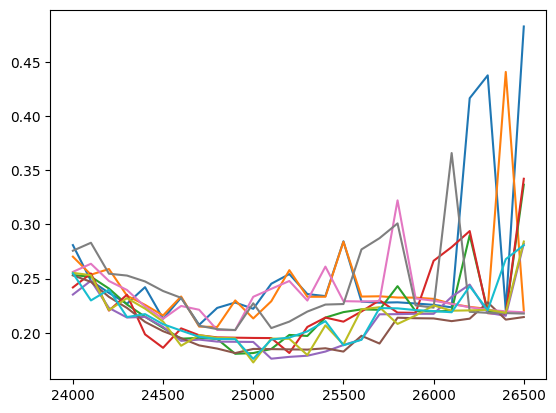

In [21]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot([int(col.split('_')[-1]) for col in cols], pred_call.iloc[i, :])